<a href="https://colab.research.google.com/github/rifkiadhim/202055202019_R.Adhim/blob/master/dataset_bawang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download rifkiadhim/dataset-bawang
!mkdir dataset

 99% 954M/962M [00:10<00:00, 155MB/s]
100% 962M/962M [00:10<00:00, 93.8MB/s]


In [4]:
!unzip /content/dataset-bawang.zip -d /content/dataset

Archive:  /content/dataset-bawang.zip
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064641.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064646.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064650.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064654.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064656.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064659.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064703.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064705.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064706.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064714.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064756.jpg  
  inflating: /content/dataset/BAWANG/Bawang Bombay/IMG_20230506_064759.jpg  
  inflating: /content/dataset/BAWANG/B

In [5]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [6]:
dataset_path = Path(r'/content/dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/dataset/BAWANG/Bawang Bombay/IMG_2023...,Bawang Bombay
1,/content/dataset/BAWANG/Bawang Bombay/IMG_2023...,Bawang Bombay
2,/content/dataset/BAWANG/Bawang Bombay/IMG_2023...,Bawang Bombay
3,/content/dataset/BAWANG/Bawang Bombay/IMG_2023...,Bawang Bombay
4,/content/dataset/BAWANG/Bawang Bombay/IMG_2023...,Bawang Bombay


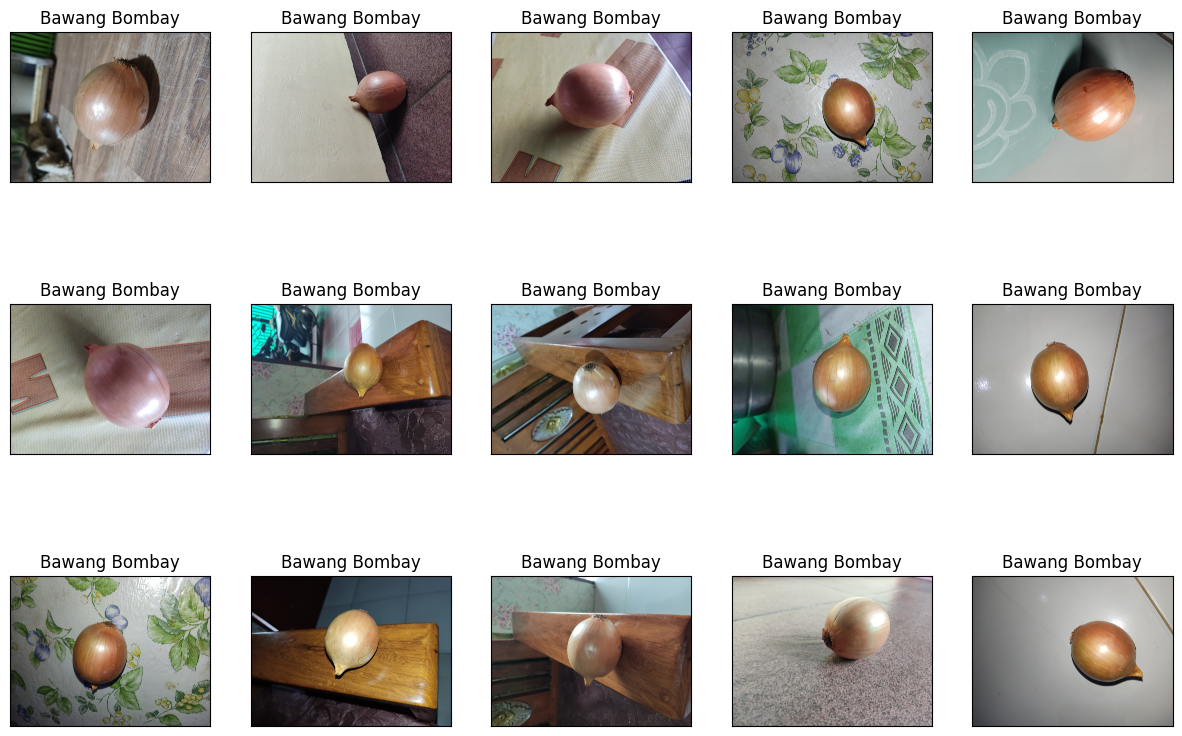

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [9]:
df.label.value_counts()

Bawang Bombay    100
Bawang Merah     100
Bawang Putih     100
Name: label, dtype: int64

In [10]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Bawang Bombay    100
Bawang Merah     100
Bawang Putih     100
Name: label, dtype: int64

In [11]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [12]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [13]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [14]:
input_shape = (200, 200, 3)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [16]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 60s 8s/step - loss: 1.1336 - accuracy: 0.3631 - val_loss: 1.0928 - val_accuracy: 0.3810
Epoch 2/100
6/6 [==============================] - 44s 8s/step - loss: 1.1059 - accuracy: 0.3750 - val_loss: 1.0960 - val_accuracy: 0.3810
Epoch 3/100
6/6 [==============================] - 44s 9s/step - loss: 1.1139 - accuracy: 0.3512 - val_loss: 1.0945 - val_accuracy: 0.3810
Epoch 4/100
6/6 [==============================] - 47s 8s/step - loss: 1.0990 - accuracy: 0.3571 - val_loss: 1.0954 - val_accuracy: 0.3810
Epoch 5/100
6/6 [==============================] - 43s 7s/step - loss: 1.0973 - accuracy: 0.3929 - val_loss: 1.0956 - val_accuracy: 0.3810
Epoch 6/100
6/6 [==============================] - 46s 8s/step - loss: 1.1004 - accuracy: 0.3452 - val_loss: 1.1030 - val_accuracy: 0.3810
Epoch 7/100
6/6 [==============================] - 46s 8s/step - loss: 1.0800 - accuracy: 0.3571 - val_loss: 1.0761 - val_accuracy: 0.3810
Epoch 8/100
6/6 [==========

In [17]:
model.save('model-1.h5')

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

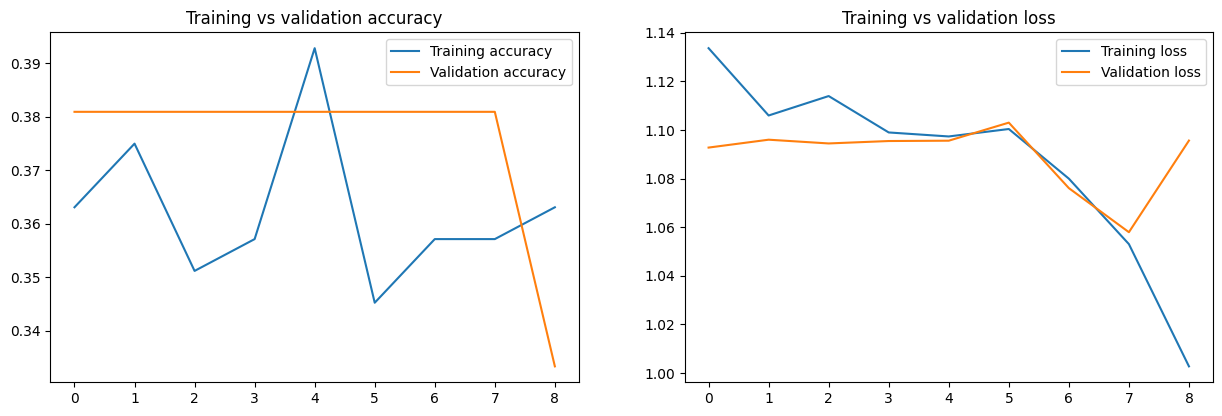

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [20]:
pred = model.predict(test)

3/3 [==============================] - 21s 7s/step


In [21]:
pred = np.argmax(pred, axis=1)

In [22]:
labels = train.class_indices

In [23]:
labels

{'Bawang Bombay': 0, 'Bawang Merah': 1, 'Bawang Putih': 2}

In [24]:
labels = dict((v,k) for k, v in labels.items())

In [25]:
labels

{0: 'Bawang Bombay', 1: 'Bawang Merah', 2: 'Bawang Putih'}

In [26]:
y_pred = [labels[k] for k in pred]

In [27]:
print(classification_report(x_test.label, y_pred))

               precision    recall  f1-score   support

Bawang Bombay       0.59      0.91      0.71        33
 Bawang Merah       0.00      0.00      0.00        33
 Bawang Putih       0.31      0.50      0.38        24

     accuracy                           0.47        90
    macro avg       0.30      0.47      0.37        90
 weighted avg       0.30      0.47      0.36        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(confusion_matrix(x_test.label, y_pred))

[[30  0  3]
 [ 9  0 24]
 [12  0 12]]


In [29]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 20s 6s/step - loss: 1.0643 - accuracy: 0.4778
